In [8]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np
import random
import json
import glob

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

import time

import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Data

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
train_path = r'/content/drive/MyDrive/ImageNet100/train.X'
test_path = r'/content/drive/MyDrive/ImageNet100/val.X'
labels_path = r'/content/drive/MyDrive/ImageNet100/Labels.json'

f = open(labels_path)
data = json.load(f)

labels = list(data.keys())

In [11]:
class ImageNet100(Dataset):
  def __init__(self, file_path, labels, transform=False):
    self.file_path = file_path
    self.labels = labels
    self.transform = transform

    self.image_paths = []

    for data_path in glob.glob(self.file_path + '/*'):
      self.image_paths.append(glob.glob(data_path + '/*'))

    self.image_paths = list(flatten(self.image_paths))
    random.shuffle(self.image_paths)

  def __getitem__(self, idx):
    label = str(self.image_paths[idx])
    image = cv2.imread(label)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    label = label.split('/')[-2]
    label = self.labels.index(label)

    if self.transform:
      image = self.transform(image)

    return image, torch.tensor(label)

  def __len__(self):
    return len(self.image_paths)

In [12]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(224),
    normalize
])

In [13]:
train_dataset = ImageNet100(train_path, labels, transform)
test_dataset = ImageNet100(test_path, labels, transform)

In [14]:
train_img, train_label = train_dataset[1000]
train_img.shape, train_label

(torch.Size([3, 224, 224]), tensor(48))

Text(0.5, 1.0, 'tensor(48)')

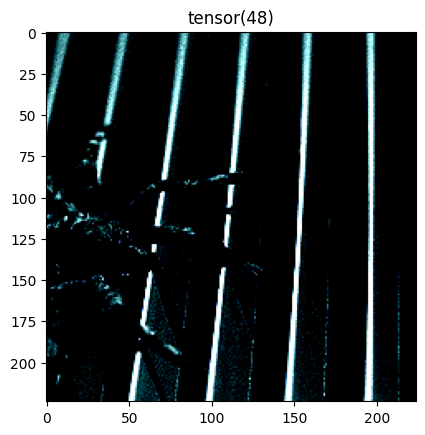

In [15]:
train_img = train_img.permute(1, 2, 0).numpy()

plt.imshow(train_img)
plt.title(train_label)

In [16]:
len(train_dataset)

130000

In [17]:
test_img, test_label = test_dataset[1000]
test_img.shape, test_label

(torch.Size([3, 224, 224]), tensor(3))

Text(0.5, 1.0, 'tensor(3)')

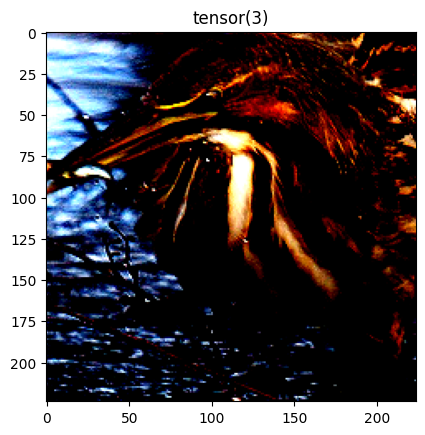

In [18]:
test_img = test_img.permute(1, 2, 0).numpy()

plt.imshow(test_img)
plt.title(test_label)

In [19]:
len(test_dataset)

5000

### Models

In [20]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
    super(ResidualBlock, self).__init__()
    self.expansion = 4
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
    self.relu = nn.ReLU()

    self.identity_downsample = identity_downsample

  def forward(self, x):
    identity = x

    #print(f'Shape of x initially: {x.shape}')
    x = self.conv1(x)
    #print(f'Shape of x after conv1: {x.shape}')
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    #print(f'Shape of x after conv2: {x.shape}')
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    #print(f'Shape of x after conv3: {x.shape}')
    x = self.bn3(x)

    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)
     # print(f'Shape of identity after downsampling: {identity.shape}')

    x += identity
    x = self.relu(x)
    #print()

    return x

In [21]:
class ResNet(nn.Module):
  def __init__(self, layer_list, num_classes, num_channels=3):
    super(ResNet, self).__init__()
    self.in_channels = 64

    self.conv1 = nn.Conv2d(num_channels, self.in_channels, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(self.in_channels)
    self.relu = nn.ReLU()

    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer0 = self.make_layer(64, layer_list[0])
    self.layer1 = self.make_layer(128, layer_list[1], stride=2)
    self.layer2 = self.make_layer(256, layer_list[2], stride=2)
    self.layer3 = self.make_layer(512, layer_list[3], stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512*4, num_classes)


  def make_layer(self, out_channels, num_res_blocks, stride=1):
    layer = []
    identity_downsample = None

    if stride!=1 or self.in_channels != 4*out_channels:
      identity_downsample = nn.Sequential(
          nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride, padding=0, bias=False),
          nn.BatchNorm2d(out_channels*4)
      )

    layer.append(ResidualBlock(self.in_channels, out_channels, identity_downsample, stride=stride))
    self.in_channels = out_channels*4

    for i in range(num_res_blocks - 1):
      layer.append(ResidualBlock(self.in_channels, out_channels))

    return nn.Sequential(*layer)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.maxpool(x)
    #print(f'Shape of x after maxpool: {x.shape}')

    x = self.layer0(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)

    return x

### Utils

In [22]:
def accuracy(y_pred, y_true):
  y_pred, y_true = y_pred.to(device), y_true.to(device)
  acc = torch.sum(y_pred.argmax(dim=1) == y_true).item() / len(y_pred) * 100
  return acc

In [23]:
def train_step(model, train_dataloader, loss_fn, optimizer, device):

  model.to(device)
  model.train()

  train_loss = 0
  train_acc = 0

  for batch, (X, y) in enumerate(train_dataloader):

    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy(y_pred, y)

    if batch % 10 == 0:
      print(f'Batch: {batch}, Loss: {loss:.4f}, Accuracy: {accuracy(y_pred, y):.2f}%')

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  return train_loss, train_acc

In [24]:
def test_step(model, test_dataloader, loss_fn, device):

  model.to(device)
  model.eval()

  test_loss = 0
  test_acc = 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)

      test_loss += loss
      test_acc += accuracy(y_pred, y)
      if batch % 10 == 0:
        print(f'Batch: {batch}, Loss: {loss:.4f}, Accuracy: {accuracy(y_pred, y):.2f}%')

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    return test_loss, test_acc

In [25]:
def plot(epoch_list, train_vals, test_vals, y_label):

  if type(vals_attn[0]) == torch.Tensor:
    for i in range(len(vals_attn)):
      vals_attn[i] = vals_attn[i].to('cpu').detach().numpy()
      vals[i] = vals[i].to('cpu').detach().numpy()

  plt.figure(figsize=(5, 4))
  plt.plot(epoch_list, train_vals, color='r', label='Train')
  plt.plot(epoch_list, test_vals, color='g', label='Test')
  title = y_label + ' vs Epochs'
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel(y_label)
  plt.legend()

In [67]:
def Transform(image_path):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.axis('off')
  plt.imshow(image)

  normalize = transforms.Normalize(
      mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
      )
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.CenterCrop(224),
      normalize
      ])

  tensor = transform(image)
  tensor = tensor.unsqueeze(dim=0)

  return tensor

In [66]:
def prediction(model, image_path, data, num_preds=5):
  tensor = Transform(image_path)

  model.eval()

  with torch.inference_mode():
    y = model(tensor)

  sorted_y = y.sort(dim=1, descending=True)
  preds = list(sorted_y.indices.squeeze()[:num_preds])

  labels = list(data.keys())

  names = []
  for i in preds:
    name = labels[i.item()]
    names.append(data[name])

  return names

In [27]:
class Metric:
  def __init__(self):
    self.values = []
    self.epochs = []

  def update(self, value, epoch):
    self.values.append(value)
    self.epochs.append(epoch)

### Training

In [28]:
num_classes = 100
BATCH_SIZE = 64
learning_rate = 0.1
epochs = 20
num_workers = 6

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f'Length of train_loader: {len(train_loader)}')
print(f'Length of test_loader : {len(test_loader)}')

resnet_layer = [3, 4, 6, 3]
ResNet50 = ResNet(resnet_layer, num_classes=num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ResNet50.parameters(), lr=learning_rate, momentum=0.8)
#scheduler = CosineAnnealingLR(optimizer, T_max=15, eta_min=0.01)

Length of train_loader: 2032
Length of test_loader : 79


In [ ]:
train_losses = Metric()
test_losses = Metric()
train_accs = Metric()
test_accs = Metric()

start_time = time.time()
for epoch in range(1, epochs+1):
  print(f'\nEpoch: {epoch}\n-------')
  train_loss, train_acc = train_step(model=ResNet50,
                                     train_dataloader=train_loader,
                                     loss_fn=criterion,
                                     optimizer=optimizer,
                                     device=device)

  train_losses.update(train_loss, epoch)
  train_accs.update(train_accs, epoch)

  print(f'\nTrain Loss = {train_loss:.5f} | Train accuracy = {train_acc:.2f}%')

  test_loss, test_acc = test_step(model=ResNet50,
                                  test_dataloader=test_loader,
                                  loss_fn=criterion,
                                  device=device)

  test_losses.update(test_loss, epoch)
  test_accs.update(test_accs, epoch)

  print(f'\nTest Loss = {test_loss:.5f} | Test accuracy = {test_acc:.2f}%')

end_time = time.time()


Epoch: 1
-------


OutOfMemoryError: ignored

In [ ]:
PATH = r'/content/drive/MyDrive/Projects/ResNet'
name = PATH + 'ResNet.pth'
torch.save(ResNet50, name)

In [ ]:
plot(train_losses.epochs, train_losses.values, test_losses.values, 'Loss')

In [ ]:
plot(train_accs.epochs, train_accs.values, test_accs.values, 'Accuracy')

In [29]:
total_params = sum(p.numel() for p in ResNet50.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 23735652


In [30]:
train_time = end_time - start_time
print(f'Time to train the model on {device} is {train_time:.4f}s')

NameError: ignored

In [31]:
summary(ResNet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Prediction

In [41]:
image_path = r'/content/drive/MyDrive/Projects/ResNet/images.jpg'

In [ ]:
prediction(ResNet50, image_path, data)

In [38]:
from torchvision.models._utils import IntermediateLayerGetter
model = models.resnet50()

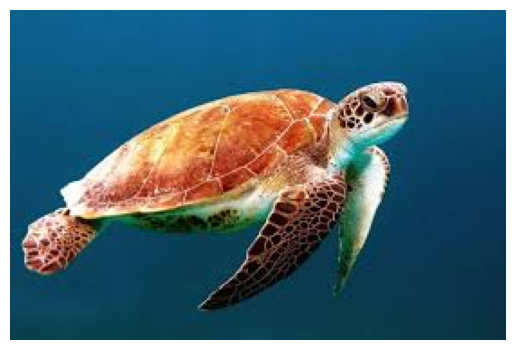

In [68]:
image = Transform(image_path)

In [64]:
return_layers = {'layer1': 0, 'layer2': 1, 'layer3': 2, 'layer4': 3}
names = {0: 'layer1', 1: 'layer2', 2: 'layer3', 3: 'layer3'}

In [40]:
model = IntermediateLayerGetter(model, return_layers=return_layers)

In [69]:
model.eval()
feature_maps = model(image)

In [71]:
processed = []
for i in feature_maps:
  feature_maps[i] = feature_maps[i].squeeze(0)
  gray_scale = torch.sum(feature_maps[i],0)
  processed.append(gray_scale.data.cpu().numpy())

In [72]:
for fm in processed:
    print(fm.shape)

(56, 56)
(28, 28)
(14, 14)
(7, 7)


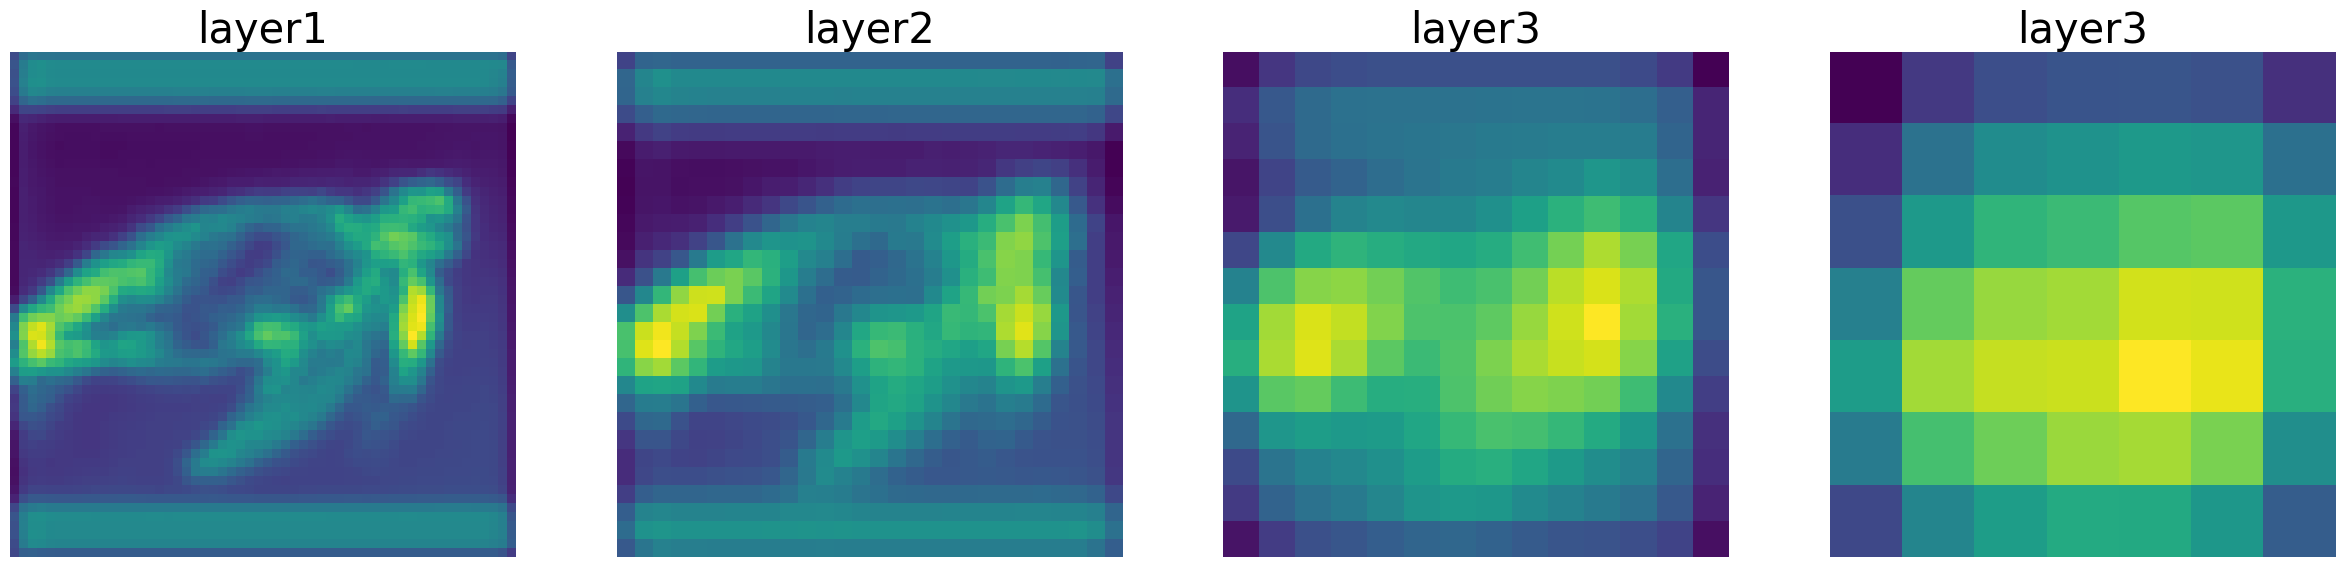

In [73]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)